In [2]:
import numpy as np
from scipy.interpolate import interp2d, interpn
from sirius._sirius_utils._math import bilinear_interpolate, interp_array
import matplotlib.pyplot as plt
import ipympl
import xarray as xr
import dask.array as da
import cngi.conversion.convert_ms as convert_ms
import cngi.conversion.convert_image as convert_image
from cngi.dio import read_vis
import numpy as np
from astropy.coordinates import SkyCoord
from sirius import calc_vis
from astropy.wcs import WCS
import time
deg_to_rad = np.pi/180
from sirius import make_ant_sky_jones, simulation
from sirius._sirius_utils._ant_jones_term import _compute_rot_coords
from sirius._sirius_utils._calc_parallactic_angles import _calc_parallactic_angles, _find_optimal_set_angle
from astropy.time import Time
from astropy.coordinates import (EarthLocation, SkyCoord, AltAz, CIRS)
import astropy.units as u
import pkg_resources

In [16]:
x = np.arange(0, 201, 1)

y = np.arange(0, 201, 1)

xx, yy = np.meshgrid(x, y)

z = np.sin(xx**2+(yy+1)**2)

In [3]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [82]:
%matplotlib ipympl
plt.figure(figsize = (8, 8))
plt.imshow(z)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
#%%timeit
f = interp2d(x, y, z, kind='linear')
test = f(51.5, 51.5)

In [84]:
#%%timeit
test = bilinear_interpolate(z, np.array([51.5]), np.array([51.5]))

In [85]:
%%timeit
f = interp2d(x, y, z, kind='linear')
test = f(51.5, 51.5)

1.47 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
test = f(51.5, 51.5)

21.5 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
test = bilinear_interpolate(z, np.array([51.5]), np.array([51.5]))

7.28 µs ± 814 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
np.allclose(f(45.5, 51.5), bilinear_interpolate(z, np.array([45.5]), np.array([51.5])))

True

In [11]:
f(45.5, 51.5)

array([-0.03263969])

In [12]:
bilinear_interpolate(z, np.array([45.5]), np.array([51.5]))

array([-0.03263969])

### Beam interpolation

In [14]:
interp_array(np.array([z+2j*z, z+1j*z, z]), np.array([2]), np.array([2]), 4, 4)

array([[0.56429666+1.1285933j ],
       [0.56429666+0.56429666j],
       [0.56429666+0.j        ]], dtype=complex64)

In [87]:
interp_array(np.array([z, 2*z, 3*z]), np.array([2]), np.array([2]), 4, 4)

array([[0.56429664+0.j],
       [1.12859327+0.j],
       [1.69288991+0.j]])

In [29]:
n_l = z.shape[0]
n_m = z.shape[1]
coords = np.array([0.5 + n_l//2, 0.5 + n_m//2])
interpn((x, y), z+2j*z, xi = coords, method = "linear")

array([0.56429664+1.12859327j])

In [21]:
np.allclose(interpn((x, y), z+2j*z, xi = coords, method = "linear"), interp_array(np.array([z+2j*z, z+1j*z, z]), np.array([2]), np.array([2]), 4, 4)[0])

True

In [27]:
%%timeit
interpn((x, y), z+2j*z, xi = coords, method = "linear")

461 µs ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%%timeit
interp_array(np.array([z+2j*z]), np.array([2]), np.array([2]), 4, 4)

250 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Testing bessel

In [5]:
from scipy.special import j1

In [ ]:
numba_scipy

In [16]:
%%timeit
j1(3)

838 ns ± 1.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
import numba
import numba_scipy.special

In [12]:
@numba.jit(nopython=True,cache=True,nogil=True)
def bessel_test(x):
    return j1(x)

In [15]:
%%timeit
bessel_test(3.0)

264 ns ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [17]:
np.allclose(j1(3), bessel_test(3.0))

True

### Testing direction_rotate

In [13]:
from sirius._sirius_utils._direction_rotate import func_R_x, _func_R_x, func_R_y, _func_R_y, func_R_z, _func_R_z, _directional_cosine, _calc_rotation_mats

In [6]:
np.allclose(func_R_x(2.5), _func_R_x(2.5))

True

In [7]:
np.allclose(func_R_y(2.5), _func_R_y(2.5))

True

In [8]:
np.allclose(func_R_z(2.5), _func_R_z(2.5))

True

In [9]:
_directional_cosine((2.1, 3.2))

array([-0.8617374 , -0.50398523, -0.05837414])

In [10]:
_calc_rotation_mats((2.1, 3.2), (1.1, 2.2))

(array([[ 0.54030231,  0.68032627,  0.49520661],
        [ 0.04912015,  0.56199787, -0.82567888],
        [-0.84003609,  0.47044082,  0.27023102]]),
 array([ 0.84003609, -0.47044082,  0.72976898]))

### Testing rot_coords

In [9]:
from sirius._sirius_utils._ant_jones_term import rot_coord, _rot_coord

In [10]:
np.allclose(rot_coord(1, 2, 3), _rot_coord(1, 2, 3))

True

### Testing Sample_j

In [14]:
from sirius.calc_vis import sample_J, sample_J_analytic

In [17]:
bm_J = np.array([[[z, z], [z, z], [z, z]], [[z, z], [z, z], [z, z]]])
bm_pa = np.array([0, 1])
bm_chan = np.array([0, 1, 2])
lmn = _directional_cosine((2.1, 3.2))
freq = 1.1
pa = 0.8
delta_l = 4
delta_m = 4

In [7]:
bm_J.shape #pa, chan, pol, imshape

(2, 3, 2, 201, 201)

In [14]:
sample_J(bm_J, bm_pa, bm_chan, delta_l, delta_m, pa, freq, lmn)

array([[0.52961546+0.j],
       [0.52961546+0.j]], dtype=complex64)

In [17]:
%%timeit
sample_J(bm_J, bm_pa, bm_chan, lmn, freq, pa, delta_l, delta_m)

[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[99.8138916]
[99.83371503]
[

### Manual check

In [17]:
sample_J(bm_J, bm_pa, bm_chan, lmn, freq, pa, delta_l, delta_m)

[99.8138916]
[99.83371503]


array([[0.52961546+0.j],
       [0.52961546+0.j]], dtype=complex64)

In [18]:
plt.figure(figsize = (8, 8))
plt.imshow(z)
plt.xlim(99, 100)
plt.ylim(99, 100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Testing apply_primary_beam

In [19]:
from sirius._sirius_utils._apply_primary_beam import apply_casa_airy_pb, _apply_casa_airy_pb, apply_airy_pb, _apply_airy_pb

In [20]:
pb_parms = {"dish_diameter":25, "blockage_diameter":2, "ipower":1}

In [21]:
print(np.allclose(apply_casa_airy_pb(lmn, 1.2e9, pb_parms), _apply_casa_airy_pb(lmn, 1.2e9, 25, 2, 1)))
print(apply_casa_airy_pb(lmn, 1.2e9, pb_parms))
print(_apply_casa_airy_pb(lmn, 1.2e9, 25, 2, 1))

True
-0.00025784633980701515
-0.0002578463398070177


/users/mbarth/sirius/sirius/sirius/_sirius_utils/_apply_primary_beam.py:23: NumbaWarning: Cannot cache compiled function "_apply_casa_airy_pb" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True,cache=True,nogil=True)


In [22]:
#Had to change r_grid to r in the function
print(np.allclose(apply_airy_pb(lmn, 1.2e9, pb_parms), _apply_airy_pb(lmn, 1.2e9, 25, 2, 1)))
print(apply_airy_pb(lmn, 1.2e9, pb_parms))
print(_apply_airy_pb(lmn, 1.2e9, 25, 2, 1))

True
-0.00019940730890659765
-0.00019940730890660027


/users/mbarth/sirius/sirius/sirius/_sirius_utils/_apply_primary_beam.py:47: NumbaWarning: Cannot cache compiled function "_apply_airy_pb" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True,cache=True,nogil=True)


### Testing Sample_j_analytic

In [5]:
_directional_cosine((2.1, 3.2))

array([-0.8617374 , -0.50398523, -0.05837414])

In [6]:
lmn = _directional_cosine((2.1, 3.2))

In [18]:
#lmn, freq, dish_diameter, blockage_diameter, ipower 
sample_J_analytic("airy", 25, 2, lmn, 1.2e9, 1) #Read up on caching...might need to write our own j1

array([3.+0.j, 0.+0.j, 0.+0.j, 3.+0.j])

In [19]:
sample_J_analytic("casa_airy", 25, 2, lmn, 1.2e9, 1)

array([3.+0.j, 0.+0.j, 0.+0.j, 3.+0.j])

### Testing numba caching

In [14]:
from numba import jit
@jit(nopython=True,cache=True,nogil=True)
def numba_dumb():
    count = 0
    for i in range(1000):
        count += sample_J_analytic(lmn, 1.2e9, 25, 2, 1, "casa_airy")[0]
    return count

In [15]:
%%timeit -n 250
numba_dumb() #Clearly numba is not dumb

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'sample_J_analytic' is not defined

In [ ]:
%%timeit -n 250
sample_J_analytic(lmn, 1.2e9, 25, 2, 1, "casa_airy")

### Test numba heterogeonous tuple arguments

In [46]:
@jit("int64(int64[:, :], int64[:])", nopython=True,cache=True,nogil=True)
#@jit(nopython=True,cache=True,nogil=True)
def big_tuple_user(tuple1, indices):
    value1 = 0
    for i in range(len(indices)):
        value1 = value1 + tuple1[indices[i]][0]
    return value1

@jit("int64(int64[:])", nopython=True,cache=True,nogil=True)
#@jit(nopython=True,cache=True,nogil=True)
def small_tuple_user(tuple1):
    value1 = 0
    value1 = value1 + tuple1[0]
    return value1

@jit(nopython=True,cache=True,nogil=True)
def tuple_tester(evil_tuple, chooser, chooser2):
    test_val = 0
    for i in range(len(chooser)):
        index = chooser[i]
        testing_numba1 = evil_tuple[index]
        if len(evil_tuple[index]) == 1:
            test_val = test_val + small_tuple_user(evil_tuple[index])
        else:
            test_val = test_val + big_tuple_user(evil_tuple[index], chooser2)
    return test_val

In [47]:
evil_tuple = (np.array(((1, 2, 3), (1, 2, 3))), np.array(((1, 2), (1, 2))), np.array((1, )))
print(evil_tuple)

(array([[1, 2, 3],
       [1, 2, 3]]), array([[1, 2],
       [1, 2]]), array([1]))


In [48]:
tuple_tester(evil_tuple, (0, 1, 2), (0, 1))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(Tuple(array(int64, 2d, C), array(int64, 2d, C), array(int64, 1d, C)), int64)
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(Tuple(array(int64, 2d, C), array(int64, 2d, C), array(int64, 1d, C)), int64)':
       No match.

During: typing of intrinsic-call at <ipython-input-46-5952e76c722c> (21)

File "<ipython-input-46-5952e76c722c>", line 21:
def tuple_tester(evil_tuple, chooser, chooser2):
    <source elided>
        index = chooser[i]
        testing_numba1 = evil_tuple[index]
        ^


### Comparing old and new sampling funcs

In [1]:
import numpy as np
c = 299792458
#from direction_rotate import _calc_rotation_mats
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d, griddata
import matplotlib.pyplot as plt
def coord_to_indx(l,m,cell_size,image_size):
    l_indx = l/cell_size[0] + image_size[0]//2
    m_indx = m/cell_size[1] + image_size[1]//2
    return l_indx, m_indx

In [2]:
import xarray as xr
#    import dask.array as da
#    from cngi.dio import read_vis
#    import numpy as np
#    from astropy.coordinates import SkyCoord
#    import time

deg_to_rad = np.pi/180
from sirius import make_ant_sky_jones, simulation
from sirius._sirius_utils._ant_jones_term import _compute_rot_coords
from sirius._sirius_utils._calc_parallactic_angles import _calc_parallactic_angles, _find_optimal_set_angle
from sirius._sirius_utils._ant_jones_term import _rot_coord
from astropy.time import Time
from astropy.coordinates import (EarthLocation, SkyCoord, AltAz, CIRS)
import astropy.units as u
import pkg_resources
from cngi.dio import read_vis
import time

In [11]:
np.load("../data/test_data/simulation_test/uvw_test.npy")

array([[[  14.03707628,  -39.67732671,    9.89426595],
        [  15.94716402,  -57.58095947,   51.18912561],
        [  18.35923053,  -80.37025382,  103.76739211],
        ...,
        [  26.87434532,  -48.95870461,  -69.68411451],
        [  56.26729172, -102.64920504, -145.9808393 ],
        [  29.3929464 ,  -53.69050043,  -76.2967248 ]],

       [[  15.48504699,  -39.25599749,    9.40245952],
        [  19.27235151,  -57.0810961 ,   50.60168426],
        [  24.07440378,  -79.77096985,  103.05884805],
        ...,
        [  25.94004692,  -48.19879507,  -70.56239173],
        [  54.31252044, -101.05814342, -147.81973694],
        [  28.37247353,  -52.85934835,  -77.2573452 ]],

       [[  16.90330676,  -38.79366007,    8.86320614],
        [  22.56062053,  -56.48665019,   49.9047319 ],
        [  29.74352013,  -79.00889448,  102.16177521],
        ...,
        [  24.95584495,  -47.46624908,  -71.40883705],
        [  52.25326205,  -99.52433378, -149.59203337],
        [  27.2974171 

In [5]:
zpc_xds

<xarray.Dataset>
Dimensions:    (chan: 16, coef_indx: 66, pol: 4)
Coordinates:
  * chan       (chan) float64 2.052e+09 2.18e+09 ... 3.844e+09 3.972e+09
  * coef_indx  (coef_indx) int64 0 1 2 3 4 5 6 7 8 ... 58 59 60 61 62 63 64 65
  * pol        (pol) int64 5 6 7 8
Data variables:
    ETA        (pol, chan, coef_indx) float64 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
    ZC         (pol, chan, coef_indx) complex128 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
Attributes:
    conversion_date:  2021-06-10
    dish_diam:        25
    name:             data/EVLA_avg_zcoeffs_SBand_lookup.csv

In [3]:
#Get Zernike models from casadata
zpc_dir = '../../sirius/data/dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr'#pkg_resources.resource_filename("data", 'data/dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr')
zpc_xds = xr.open_zarr(zpc_dir)
beam_models = [zpc_xds]
tel_dir = '/users/mbarth/sirius/sirius/data/telescope_layout/data/vla.d.tel.zarr'
tel_xds = xr.open_zarr(tel_dir)
mxds = read_vis('../data/fm_sim_data/fm_sim_data.vis.zarr')
print(zpc_xds.chan)

<xarray.DataArray 'chan' (chan: 16)>
array([2.052e+09, 2.180e+09, 2.308e+09, 2.436e+09, 2.564e+09, 2.692e+09,
       2.820e+09, 2.948e+09, 3.076e+09, 3.204e+09, 3.332e+09, 3.460e+09,
       3.588e+09, 3.716e+09, 3.844e+09, 3.972e+09])
Coordinates:
  * chan     (chan) float64 2.052e+09 2.18e+09 2.308e+09 ... 3.844e+09 3.972e+09


In [4]:
#########Setup parameters for uvw calculation###########
ant_pos = mxds.ANTENNA.POSITION.values # [n_ant x 3]
time_str = mxds.xds0.time.values#[0:1]        # [n_time]
site = 'VLA'
phase_center = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5')
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad])[None,:] #field phase centre, [(n_time)_s x 2]. This example only has a single phase center.

ant1 = mxds.xds0.ANTENNA1.values
ant2 = mxds.xds0.ANTENNA2.values
#########################################################

uvw_parms = {}
uvw_parms['calc_method'] = 'astropy'
uvw_parms['site'] = 'vla'
uvw_parms['auto_corr'] = False

uvw = mxds.xds0.UVW.values  
print(uvw.shape)

(60, 351, 3)


25 [3.e+09]
Total time 0.8801460266113281
<xarray.Dataset>
Dimensions:  (chan: 1, l: 500, m: 500, model: 1, pa: 6, pol: 4)
Coordinates:
  * chan     (chan) float64 3e+09
  * l        (l) float64 0.03657 0.03643 0.03628 ... -0.03614 -0.03628 -0.03643
  * m        (m) float64 -0.03657 -0.03643 -0.03628 ... 0.03614 0.03628 0.03643
  * pa       (pa) float64 0.0 0.5751 0.7651 0.7752 0.7854 1.571
  * pol      (pol) int64 0 1 2 3
Dimensions without coordinates: model
Data variables:
    J        (model, pa, chan, pol, l, m) complex128 (-0.0015533528739918353-...


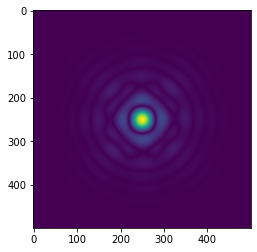

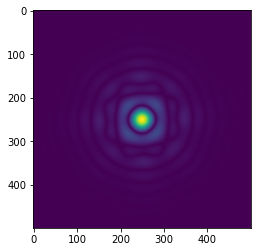

In [5]:
#Create J_xds from zpc
pb_parms = {}
pb_parms['fov_scaling'] = 15
#pb_parms['fov_scaling'] = 7
#pb_parms['fov_scaling'] = 9
#pb_parms['mueller_selection'] = np.array([0])#np.arange(16) #np.array([0,5,10,15])#np.arange(16)
pb_parms['mueller_selection'] = np.arange(16)
pb_parms['zernike_freq_interp'] = 'nearest'
pb_parms['freq'] = np.array([3.00e+09])
pb_parms['pa'] = np.array([0.0, 0.7323*np.pi/4, 0.9741*np.pi/4, 0.987*np.pi/4, np.pi/4, np.pi/2])
pb_parms['image_size'] = np.array([500,500])
print(zpc_xds.dish_diam,pb_parms['freq'])

# time, ant, chan, pol, l, m
start = time.time()
J_xds = make_ant_sky_jones([zpc_xds],pb_parms) #[None,None,:,:,:,:]
print("Total time", time.time()-start)
pol = 0
print(J_xds)
J_sub = J_xds.J.isel(model=0,pa=0,pol=pol,chan=0)
plt.figure()
plt.imshow(np.abs(J_sub))
J_sub = J_xds.J.isel(model=0,pa=3,pol=pol,chan=0)
plt.figure()
plt.imshow(np.abs(J_sub))
plt.show()

In [6]:
#Setup Beam Models
ant_pos = mxds.ANTENNA.POSITION.values
n_ant = len(ant_pos)

airy_disk_parms =  {'pb_func':'casa_airy','dish_diameter':24.5,'blockage_diameter':0.0}
beam_model_map = np.zeros(len(ant_pos), dtype=int)
#beam_models = [zpc_xds,airy_disk_parms]
beam_models = [J_xds]
#beam_models = [airy_disk_parms]
#beam_models = [airy_disk_parms,airy_disk_parms]
beam_model_map = np.zeros(n_ant,dtype=int)
#beam_model_map[1] = 1
#beam_model_map[10] = 1

beam_parms = {}
beam_parms['fov_scaling'] = 15
beam_parms['mueller_selection'] = np.arange(16)
beam_parms['zernike_freq_interp'] = 'nearest'
#beam_parms['freq'] = mxds.xds0.chan.values
beam_parms['pa_radius'] = 0.2
beam_parms['image_size'] = np.array([500,500])#np.array([2000,2000])

freq_chan = mxds.xds0.chan.values
pol = mxds.xds0.pol.values
######################

In [7]:
#Setup sources
#pointing_ra_dec:  [n_time, n_ant, 2]          (singleton: n_time, n_ant)
pointing_ra_dec = None #np.zeros((1, 1, 2)) #Singleton

#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
point_source_skycoord = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

# NB n_pol is no longer singleton
#point_source_flux: [n_time, n_chan, n_pol, n_point_sources] (singleton: n_time, n_chan)
point_source_flux = np.array([2.5, 0, 0, 2.5])[None,None,:,None] #has to be in instrument polarization: [RR,RL,LR,LL] or [XX,XY,YX,YY]. All 4 values are needed.
pb_limit = 0.2

###############################
vis_data, uvw =simulation(point_source_flux, point_source_ra_dec, pointing_ra_dec, phase_center_ra_dec, beam_parms,beam_models,beam_model_map,uvw_parms, ant_pos, time_str, freq_chan, pol, ant1, ant2, pb_limit, uvw)

[<xarray.Dataset>
Dimensions:  (chan: 1, l: 500, m: 500, model: 1, pa: 6, pol: 4)
Coordinates:
  * chan     (chan) float64 3e+09
  * l        (l) float64 0.03657 0.03643 0.03628 ... -0.03614 -0.03628 -0.03643
  * m        (m) float64 -0.03657 -0.03643 -0.03628 ... 0.03614 0.03628 0.03643
  * pa       (pa) float64 0.0 0.5751 0.7651 0.7752 0.7854 1.571
  * pol      (pol) int64 0 1 2 3
Dimensions without coordinates: model
Data variables:
    J        (model, pa, chan, pol, l, m) complex128 (-0.0015533528739918353-...]
pol [5 6 7 8]
bm_J (6, 1, 4, 500, 500)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


/users/mbarth/sirius/sirius/sirius/calc_vis.py:166: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 1d, A))
  flux_scaled = np.dot(M,flux)
/users/mbarth/sirius/sirius/sirius/calc_vis.py:201: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 1d, A))
  flux_scaled = np.dot(M,flux)


time 13.779038190841675


In [9]:
vis_data.shape

(60, 351, 1, 4)

In [10]:
np.save("vis_data_test.npy", vis_data)

In [11]:
np.save("uvw_test.npy", uvw)

### List of questions:

1. Do we need any more tests for lower-level functions? Current tests: 2d interpolation/3d interpolation/interpolation w/complex numbers, sample_J/sample_J_analytic, simulation

3. Image plane approximation: what happens if two sources are at very different n values?



Polarization correlation arrays: XX, XY, YX, YY